<a href="https://colab.research.google.com/github/Sim98B/MushroomVision/blob/main/MushD4/MushDetector4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Detector

https://www.youtube.com/watch?v=vT8_oE91R-w

## Setup

In [1]:
# Importing main libraries
try:
  import torch
  import torchvision
  import torchinfo
except:
  print("[INFO] Torch and Torchvision not installed, downloading")
  !pip install -q torch torchvision torchinfo
import torch
print(f"torch: {torch.__version__}")
import torchvision
print(f"torchvision: {torchvision.__version__}")
import torchinfo
print(f"torchinfo: {torchinfo.__version__}")

# Utilities
import os
from pathlib import Path
import requests
import shutil
from timeit import default_timer as timer
import itertools
import warnings
warnings.filterwarnings("ignore")

# Manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Neural networks
from torch import nn
from torchvision import transforms
import torchvision.models
from torchinfo import summary

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Cloning GitHub repository
!git clone https://github.com/Sim98B/MushroomVision
!mv MushroomVision/Modules/Libraries .
!mv MushroomVision/MV4/Models .

# Custom functions
from Libraries import data, extractors, model_ops, utils

shutil.rmtree("MushroomVision")

[INFO] Torch and Torchvision not installed, downloading
torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
torchinfo: 1.8.0
Cloning into 'MushroomVision'...
remote: Enumerating objects: 64212, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 64212 (delta 110), reused 90 (delta 63), pack-reused 64041
Receiving objects: 100% (64212/64212), 801.16 MiB | 31.26 MiB/s, done.
Resolving deltas: 100% (1072/1072), done.
Updating files: 100% (1740/1740), done.


In [4]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
print(f'GPU name: {torch.cuda.get_device_name()}\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device is: {device}\n')
print(f'Total number of GPUs: {torch.cuda.device_count()}')

GPU name: Tesla V100-SXM2-16GB

Device is: cuda

Total number of GPUs: 1


In [4]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [30]:
weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
get_ = weights.transforms()
get_

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
train_dataset = torchvision.datasets.CIFAR100(root = './data_src', train=True, download = True, transform = transform)
test_dataset = torchvision.datasets.CIFAR100(root = './data_src', train=False, download = True, transform = transform)

100%|██████████| 169001437/169001437 [00:05<00:00, 29696461.64it/s]


Extracting ./data_src/cifar-100-python.tar.gz to ./data_src
Files already downloaded and verified


In [8]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [9]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [10]:
classes = train_dataset.classes

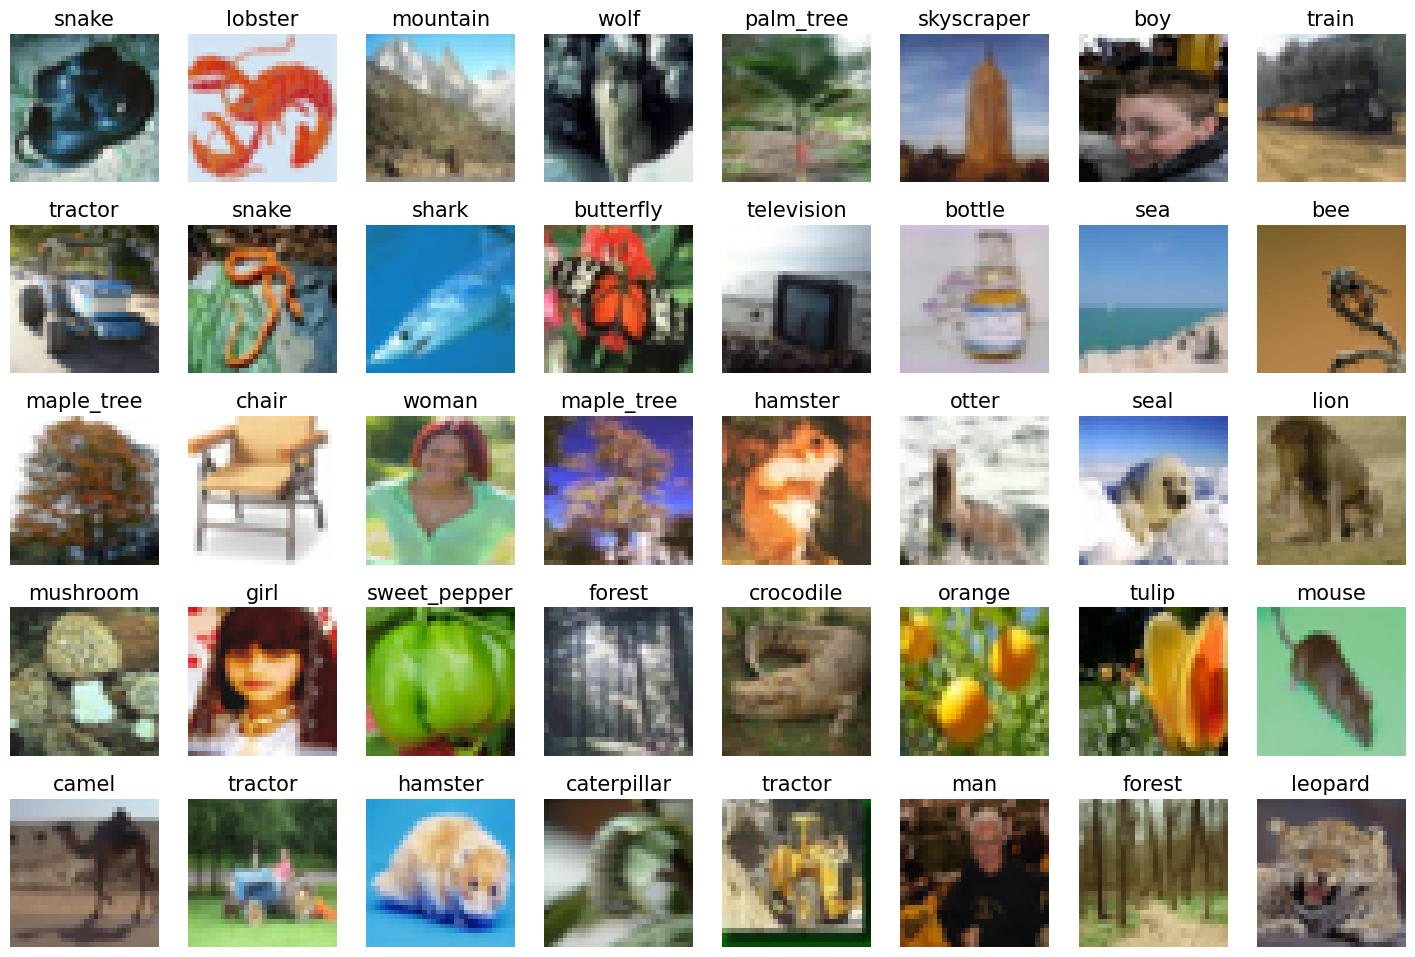

In [11]:
pos = 0
fig = plt.figure(figsize=(18,12))
for image in range(40,80):
  fig.add_subplot(5,8,pos+1)
  plt.imshow(train_dataset.data[image])
  plt.title(classes[train_dataset.targets[image]], fontsize = 15)
  plt.axis(False)
  pos += 1

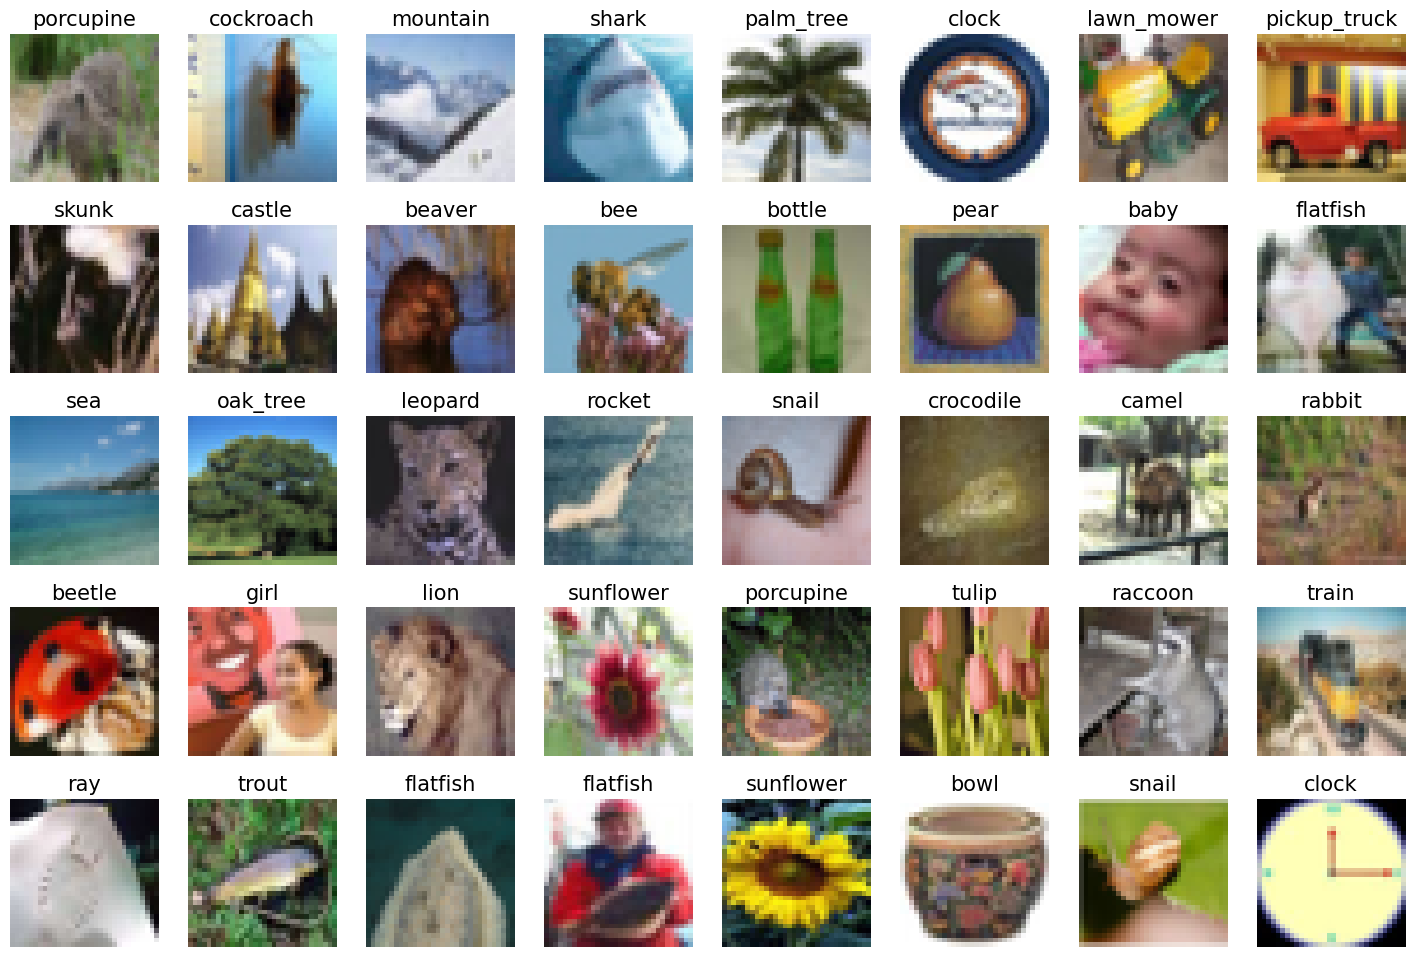

In [12]:
pos = 0
fig = plt.figure(figsize=(18,12))
for image in range(40,80):
  fig.add_subplot(5,8,pos+1)
  plt.imshow(test_dataset.data[image])
  plt.title(classes[test_dataset.targets[image]], fontsize = 15)
  plt.axis(False)
  pos += 1

In [31]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)
print(len(train_dataloader))
print(len(test_dataloader))

1563
313


In [2]:
net = torchvision.models.efficientnet_v2_l(pretrained = True)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:06<00:00, 78.9MB/s]


In [5]:
model = net.to(device)
#summary(model, input_size=(32,3, 224,224))

In [ ]:
#model.parameters

In [6]:
new_model = torchvision.models.efficientnet_v2_l(pretrained=True)

for param in new_model.parameters():
  param.requires_grad = False

new_model.classifier = nn.Sequential()
new_model.classifier.add_module("drop1", nn.Dropout(p = 0.4, inplace = True))
new_model.classifier.add_module("linr1", nn.Linear(in_features = 1280, out_features = 1000))
new_model.classifier.add_module("drop2", nn.Dropout(p = 0.4, inplace = True))
new_model.classifier.add_module("linr2", nn.Linear(in_features = 1000, out_features = 100))

In [ ]:
new_model = new_model.to(device)
summary(new_model, input_size = (32,3,224,224))

In [ ]:
new_model.parameters

In [38]:
def train_batch(data, labels, model, criterion, optimizer):
  model.train()
  data = data.to(device)
  labels = labels.to(device)
  output = model(data)
  loss = criterion(output, labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [39]:
with torch.inference_mode():
  def test_batch(data, labels, model, criterion):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    return loss

In [40]:
with torch.inference_mode():
  def accuracy(data, labels, model):
    model.eval()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    _, pred_labels = output.max(-1)
    correct = (pred_labels == labels)
    return correct.cpu().detach().numpy().tolist()

In [41]:
new_model = new_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(new_model.parameters(), lr = 0.01)

In [42]:
from tqdm.auto import tqdm

In [45]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 5

train_loss, test_loss = [], []
train_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
  train_losses, test_losses = [], []
  train_accuracies, test_accuracies = [], []

  for data, labels in train_dataloader:
    trn_batch_loss = train_batch(data, labels, new_model, criterion, optimizer)
    train_losses.append(trn_batch_loss.item())
    trn_batch_correct = accuracy(data, labels, new_model)
    train_accuracies.extend(trn_batch_correct)

  train_per_epoch_loss = np.array(train_losses).mean()
  train_per_epoch_accuracy = np.mean(train_accuracies)

  for data, labels in test_dataloader:
    tst_batch_loss = test_batch(data, labels, new_model, criterion)
    test_losses.append(tst_batch_loss.item())
    tst_batch_correct = accuracy(data, labels, new_model)
    test_accuracies.extend(tst_batch_correct)

  test_per_epoch_loss = np.array(test_losses).mean()
  test_per_epoch_accuracy = np.mean(test_accuracies)

  train_loss.append(train_per_epoch_loss)
  train_accuracy.append(train_per_epoch_accuracy)
  test_loss.append(test_per_epoch_loss)
  test_accuracy.append(test_per_epoch_accuracy)

  print(f'Epoch: {epoch + 1}/{n_epochs}\t| Train loss: {train_per_epoch_loss:.4f} | ', end = '')
  print(f'Test loss: {test_per_epoch_loss:.4f} | Train accuracy: {train_per_epoch_accuracy:.3%} | ', end = '')
  print(f'Test accuracy: {test_per_epoch_accuracy:.3%}')

Epoch: 1/5	| Train loss: 1.2899 | Test loss: 1.0836 | Train accuracy: 78.646% | Test accuracy: 70.310%


KeyboardInterrupt: ignored

In [46]:
for data, labels in test_dataloader:
    tst_batch_loss = test_batch(data, labels, new_model, criterion)
    test_losses.append(tst_batch_loss.item())
    tst_batch_correct = accuracy(data, labels, new_model)
    test_accuracies.extend(tst_batch_correct)

In [47]:
os.mkdir("EffNetV2l")

In [50]:
utils.save_model(model = new_model,
                 target_dir = "EffNetV2l",
                 model_name = "Model100.pth")

[INFO] Saving model to: EffNetV2l/Model100.pth


In [51]:
os.path.getsize("EffNetV2l/Model100.pth")

477078158

In [52]:
a = os.path.getsize("EffNetV2l/Model100.pth")/1024
b = a/1024
b

454.97718620300293

In [58]:
modello = torchvision.models.efficientnet_v2_l(pretrained=True)

for param in modello.parameters():
  param.requires_grad = False

modello.classifier = nn.Sequential()
modello.classifier.add_module("drop1", nn.Dropout(p = 0.4, inplace = True))
modello.classifier.add_module("linr1", nn.Linear(in_features = 1280, out_features = 1000))
modello.classifier.add_module("drop2", nn.Dropout(p = 0.4, inplace = True))
modello.classifier.add_module("linr2", nn.Linear(in_features = 1000, out_features = 100))

In [59]:
modello.load_state_dict(torch.load('EffNetV2l/Model100.pth'))

<All keys matched successfully>

In [60]:
pred = model_ops.make_predictions(model = modello,
                                  test_dataloader = test_dataloader,
                                  device = device)

In [61]:
accuracy_score(pred["true_labels"], pred["predictions"])

0.6996

In [ ]:
new_model.load_state_dict(torch.load('Model100.pth'))